In [7]:
from person_state_estimation import PersonStateEstimation
import pandas as pd
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# for indiviualized models
USE_GENERALIZED = True

if not USE_GENERALIZED:
    id_mapping = {'03DEQR1O': 18, '25NQFBB2': 19, '5J7PWO3G': 20, 'Q4GTE6L4': 14, 'J0YH72SI': 10, '1PE38CJI': 4, '6XTLNK55': 6, 'PTEM0K27': 12, 'Q4ABT87L': 13, 'A9XL9U1N': 7, '1MBU59SJ': 3, '6RGY40ES': 5, 'SYBO5F61': 15, 'F41CCF9W': 9, 'Z7U8NLC9': 17, 'M4OE3RP5': 11, 'U3L9LFS0': 16, 'COT085MQ': 8, '76HKXYD3': 2, '1CZ1CL1P': 1}


In [9]:
def parse_yaml_config(config_file):
    if config_file and os.path.isfile(config_file):
        configs = {}
        with open(config_file, 'r') as infile:
            configs = yaml.safe_load(infile)

        return configs
    else:
        print("Config not found or not given")

In [10]:
config = parse_yaml_config("person_state_estimation_config.yaml")
path = ""
person_state_estimator = PersonStateEstimation(config, path)

if USE_GENERALIZED:
    person_state_estimator.load_classifier("models/migrave_engagement_model_xgboost.joblib")

In [11]:
df = pd.read_csv("data/openface_tablet.csv")

if USE_GENERALIZED:
    df_cpy = df.copy(deep=True)
    df_cpy.drop(['participant_id', 'secs', 'nsecs'], inplace=True, axis=1)

    df = df[['participant_id', 'secs']]
    df['engagement'] = 0

    #for index, row in df_cpy.iterrows():

        #row = row.to_frame(name=0).T
        #eng_val, score_val = person_state_estimator.estimate_engagement(row)
        #df.loc[index, 'engagement'] = eng_val

    eng_val, score_val = person_state_estimator.estimate_engagement(df_cpy)
    df['engagement'] = eng_val

    tablet_df = df.groupby(["participant_id", "secs", "engagement"]).size().unstack(fill_value=0)

    tablet_df['eng_tab'] = None

    for idx,row in tablet_df.iterrows():
        val_sum = row[-1] + row[1]
        tablet_df.loc[idx, 'eng_tab'] = -1*row[-1]/val_sum + 1*row[1]/val_sum
else:
    df_new = df.copy(deep=True)
    df_new = df_new[['participant_id', 'secs']]
    df_new['engagement'] = 0

    for participant in df['participant_id'].unique():
        df_cpy = df.copy(deep=True).loc[df['participant_id']==participant]
        df_cpy.drop(['participant_id', 'secs', 'nsecs'], inplace=True, axis=1)
        person_state_estimator.load_classifier(f"models/individualized_xgboost_trained_on_{id_mapping[participant]}_train_percentage_0.9.joblib")
        engagement = []
        score = []
        for row in df_cpy.to_numpy():
            eng_val, score_val = person_state_estimator.estimate_engagement(row)
            engagement.append(eng_val)
            score.append(score_val)
        df_new.loc[df_new['participant_id']==participant, 'engagement'] = engagement

    tablet_df = df_new.groupby(["participant_id", "secs", "engagement"]).size().unstack(fill_value=0)

    tablet_df['eng_tab'] = None

    for idx,row in tablet_df.iterrows():
        val_sum = row[-1] + row[0] + row[1]
        tablet_df.loc[idx, 'eng_qt'] = -1*row[-1]/val_sum + 0*row[0]/val_sum + 1*row[1]/val_sum

In [12]:
df1 = pd.read_csv("data/openface_qt.csv")

if USE_GENERALIZED:
    df1_cpy = df1.copy(deep=True)
    df1_cpy.drop(['participant_id', 'secs', 'nsecs'], inplace=True, axis=1)

    df1 = df1[['participant_id', 'secs']]
    df1['engagement'] = 0

    # for index, row in df1_cpy.iterrows():
    #     row = row.to_frame(name=0).T
    #     eng_val, score_val = person_state_estimator.estimate_engagement(row)
    #     df1.loc[index, 'engagement'] = eng_val

    eng_val, score_val = person_state_estimator.estimate_engagement(df1_cpy)
    df1['engagement'] = eng_val

    qt_df = df1.groupby(["participant_id", "secs", "engagement"]).size().unstack(fill_value=0)

    qt_df['eng_qt'] = None

    for idx,row in qt_df.iterrows():
        val_sum = row[-1] + row[1]
        qt_df.loc[idx, 'eng_qt'] = -1*row[-1]/val_sum + 1*row[1]/val_sum
else:
    df1_new = df1.copy(deep=True)
    df1_new = df1_new[['participant_id', 'secs']]
    df1_new['engagement'] = 0

    for participant in df1['participant_id'].unique():
        df1_cpy = df1.copy(deep=True).loc[df1['participant_id']==participant]
        df1_cpy.drop(['participant_id', 'secs', 'nsecs'], inplace=True, axis=1)
        person_state_estimator.load_classifier(f"models/individualized_xgboost_trained_on_{id_mapping[participant]}_train_percentage_0.9.joblib")
        engagement = []
        score = []
        for row in df1_cpy.to_numpy():
            eng_val, score_val = person_state_estimator.estimate_engagement(row)
            engagement.append(eng_val)
            score.append(score_val)
        df1_new.loc[df1_new['participant_id']==participant, 'engagement'] = engagement

    qt_df = df1_new.groupby(["participant_id", "secs", "engagement"]).size().unstack(fill_value=0)

    qt_df['eng_qt'] = None

    for idx,row in qt_df.iterrows():
        val_sum = row[-1] + row[0] + row[1]
        qt_df.loc[idx, 'eng_qt'] = -1*row[-1]/val_sum + 0*row[0]/val_sum + 1*row[1]/val_sum

In [13]:
# We do not want to merge data, because engagement from the tablet is wrongly estimated
#eng_df = pd.merge(left=qt_df, right=tablet_df, on=['participant_id', 'secs'])
eng_df = qt_df
qt = eng_df.groupby("participant_id").get_group('1CZ1CL1P')['eng_qt']
#tab = eng_df.groupby("participant_id").get_group('1CZ1CL1P')['eng_tab']

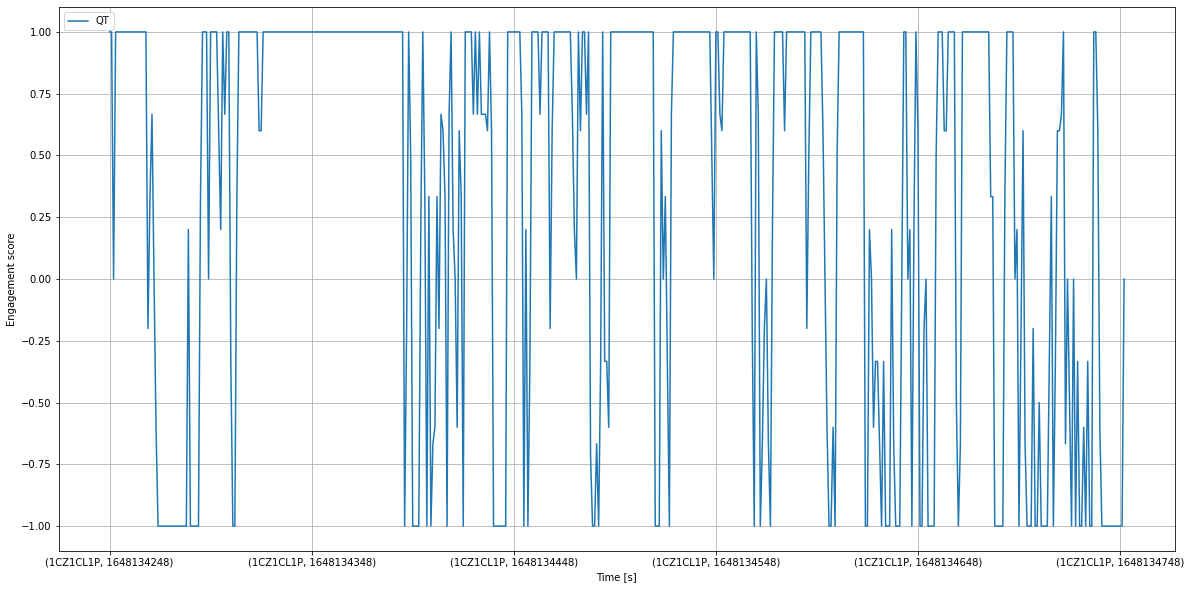

In [14]:
plt.figure(figsize=(20, 10))
ax1 = qt.plot(label='QT')
#ax1 = tab.plot(label='Tablet')
h1, l1 = ax1.get_legend_handles_labels()
plt.legend(h1, l1, loc=2)
plt.ylabel("Engagement score")
plt.xlabel("Time [s]")
plt.grid()

In [15]:
#eng_df = eng_df[["eng_qt", "eng_tab"]]
eng_df = eng_df[["eng_qt"]]
eng_df_fin = eng_df.reset_index(level=["participant_id", "secs"])

In [16]:
eng_df_fin.to_csv("output/eng_final.csv", header=True, index=None, sep=',', float_format='%10.4f', mode='w')